In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score, accuracy_score, classification_report, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import joblib

In [4]:
data = pd.read_csv("Crop_recommendationV2.csv")
print("Data loaded successfully.")

Data loaded successfully.


Data Visualization

In [5]:
data.head()

,N,P,K,temperature,humidity,ph,rainfall,label,soil_moisture,soil_type,...,organic_matter,irrigation_frequency,crop_density,pest_pressure,fertilizer_usage,growth_stage,urban_area_proximity,water_source_type,frost_risk,water_usage_efficiency
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,29.446064,2,...,3.121395,4,11.743910,57.607308,188.194958,1,2.719614,3,95.649985,1.193293
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice,12.851183,3,...,2.142021,4,16.797101,74.736879,70.963629,1,4.714427,2,77.265694,1.752672
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice,29.363913,2,...,1.474974,1,12.654395,1.034478,191.976077,1,30.431736,2,18.192168,3.035541
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice,26.207732,3,...,8.393907,1,10.864360,24.091888,55.761388,3,10.861071,3,82.818720,1.273341
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice,28.236236,2,...,5.202285,3,13.852910,38.811481,185.259702,2,47.190777,3,25.466499,2.578671


In [6]:
data.columns

Index(['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label',
       'soil_moisture', 'soil_type', 'sunlight_exposure', 'wind_speed',
       'co2_concentration', 'organic_matter', 'irrigation_frequency',
       'crop_density', 'pest_pressure', 'fertilizer_usage', 'growth_stage',
       'urban_area_proximity', 'water_source_type', 'frost_risk',
       'water_usage_efficiency'],
      dtype='object')

In [7]:
# check for null values

print(data.isnull().values.any())

False


In [8]:
# Separate features (X) and target variables (y)
# X = data.drop(columns=['water_usage_efficiency', 'frost_risk', 'irrigation_frequency',
#                          'crop_density', 'pest_pressure', 'fertilizer_usage', 'label', 'P', 'K'])
X = data.drop(columns=['label', 'P', 'K'])
y_reg = data[['P','K']]
y_clf = data['label']

# Encode categorical columns in X if needed
for col in X.columns:
    if X[col].dtype == 'object':
        print(f"Encoding categorical feature: {col}")
        label_encoder_col = LabelEncoder()
        X[col] = label_encoder_col.fit_transform(X[col])


# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)


# Encode the classification target variable
label_encoder = LabelEncoder()
y_clf = label_encoder.fit_transform(y_clf)

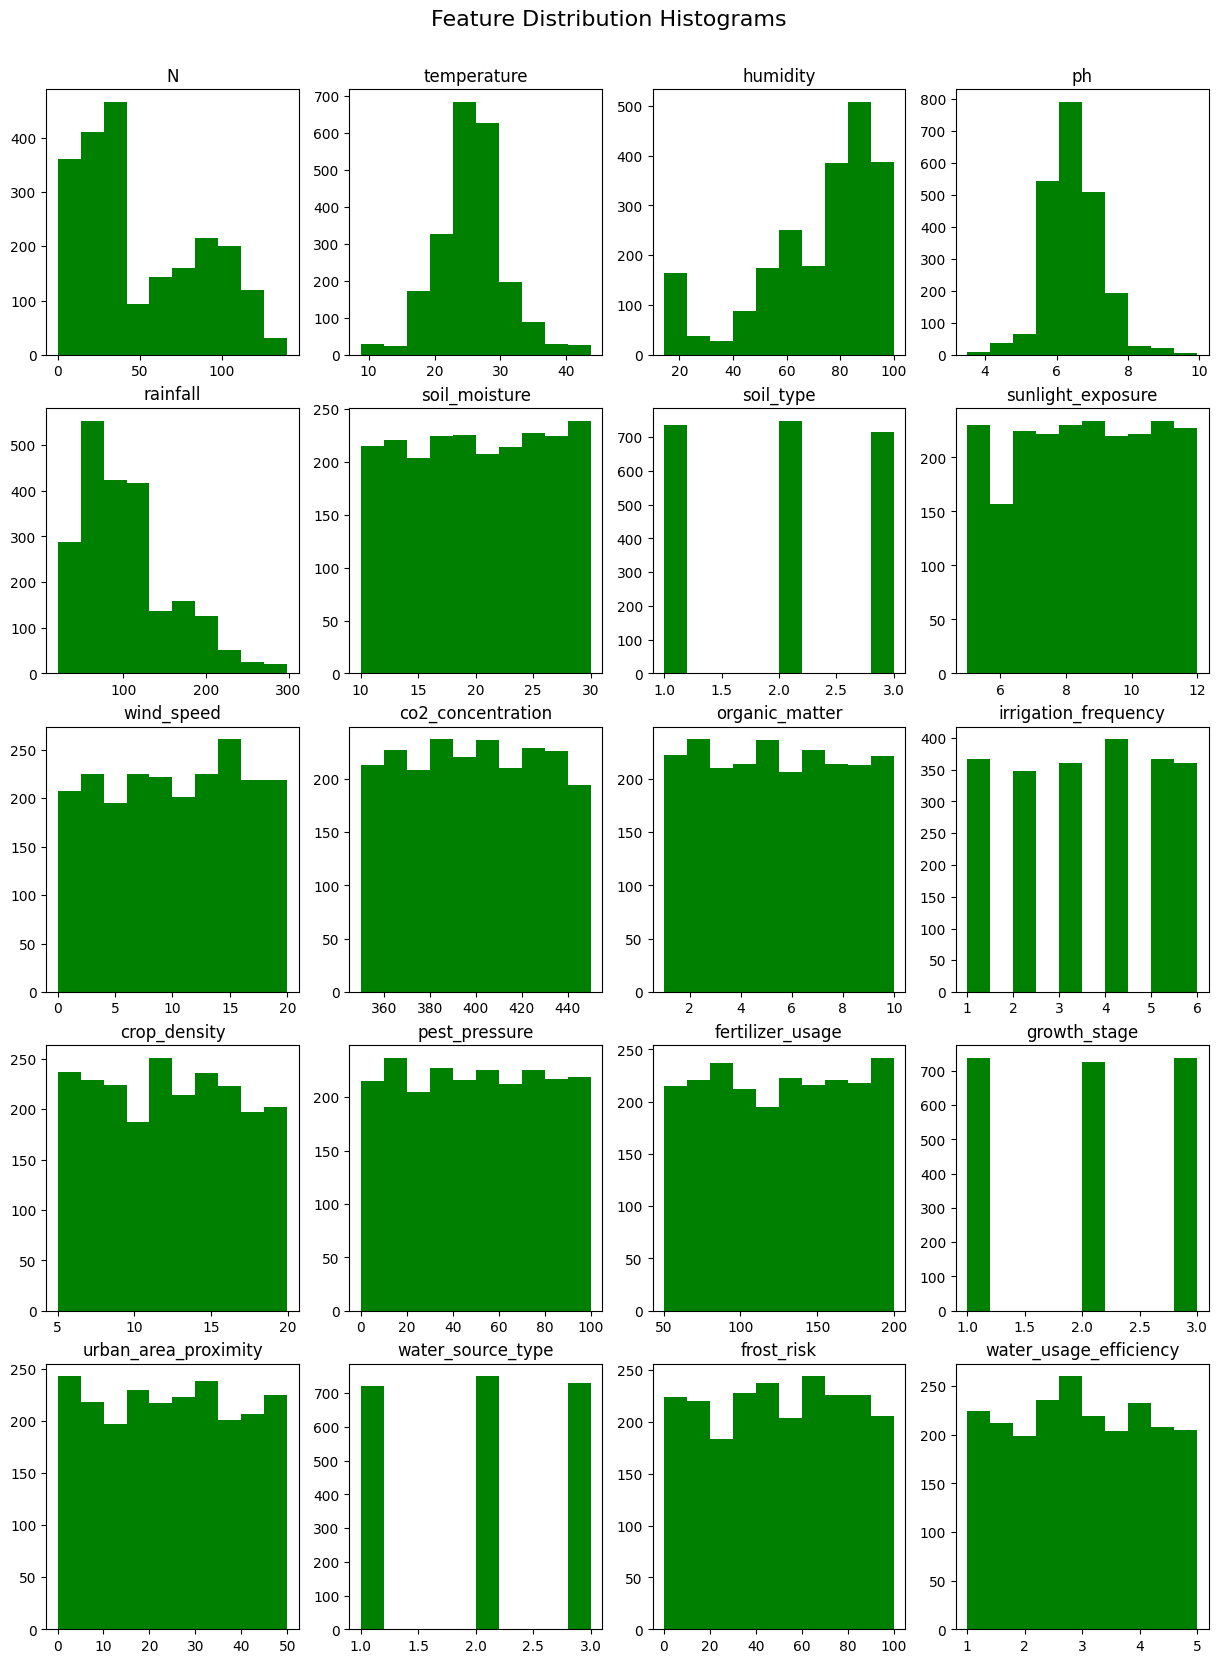

In [9]:
# plot histograms of each feature
import math

num_features = X.shape[1]
cols = 4
rows = math.ceil(num_features / cols)

fig, axs = plt.subplots(rows, cols, figsize=(15, 4 * rows))
fig.suptitle('Feature Distribution Histograms', y=0.92, fontsize=16)

axs = axs.flatten()  
for i, column in enumerate(X.columns):
    axs[i].hist(X[column], color='green')
    axs[i].set_title(column)


plt.show()


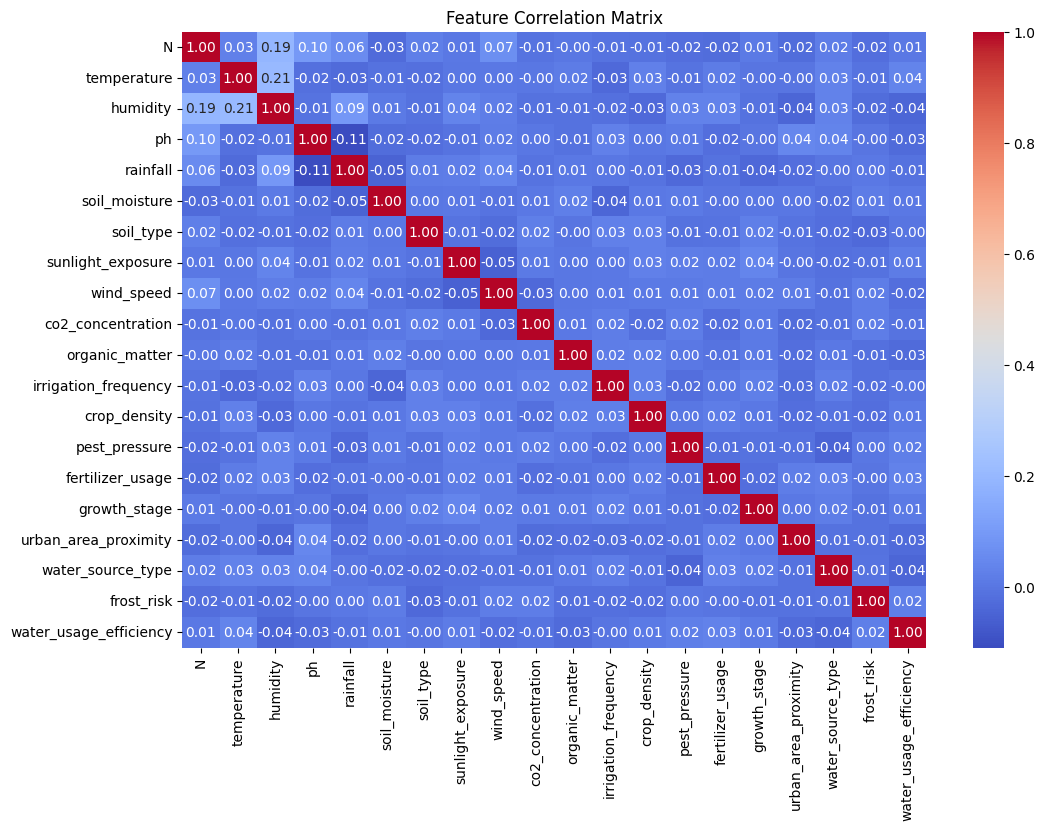

In [10]:
# Compute correlation matrix
corr_matrix = X.corr()

# Plot heatmap to visualize correlations
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()


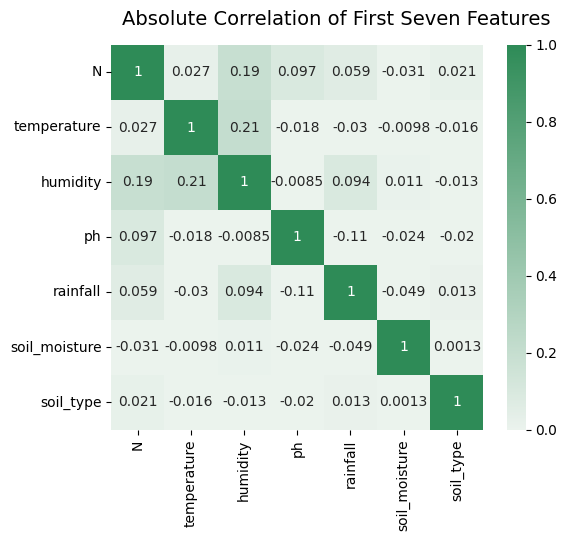

In [11]:
# plot correlation between first 7 features

fig, ax = plt.subplots(figsize=(6, 5))
fig.suptitle('Absolute Correlation of First Seven Features', y=0.95, fontsize=14)

sns.heatmap(corr_matrix.iloc[0:7,0:7], annot=True, ax=ax, vmin=0, vmax=1,
            cmap=sns.light_palette('seagreen', as_cmap=True))
plt.show()

In [12]:
df_no_labels = X.iloc[:,0:7]
features = df_no_labels.columns
for i in range(len(features)):
    print(features[i] + ':', variance_inflation_factor(df_no_labels.values, i))

N: 3.027624719375947
temperature: 22.905851658452992
humidity: 12.029986309203982
ph: 29.955699465609793
rainfall: 4.37700300026025
soil_moisture: 11.695274943392375
soil_type: 6.641116319241758


Model and Evaluation

In [13]:
# Split data into training, validation, and testing sets
X_train, X_temp, y_reg_train, y_reg_temp, y_clf_train, y_clf_temp = train_test_split(
    X_scaled, y_reg, y_clf, test_size=0.3, random_state=42
)
X_val, X_test, y_reg_val, y_reg_test, y_clf_val, y_clf_test = train_test_split(
    X_temp, y_reg_temp, y_clf_temp, test_size=0.5, random_state=42
)

In [14]:
# --- Model Training---
gbr = MultiOutputRegressor(GradientBoostingRegressor(random_state=42))
gbr.fit(X_train, y_reg_train)

MultiOutputRegressor(estimator=GradientBoostingRegressor(random_state=42))

Text(0.5, 0, 'Importance')

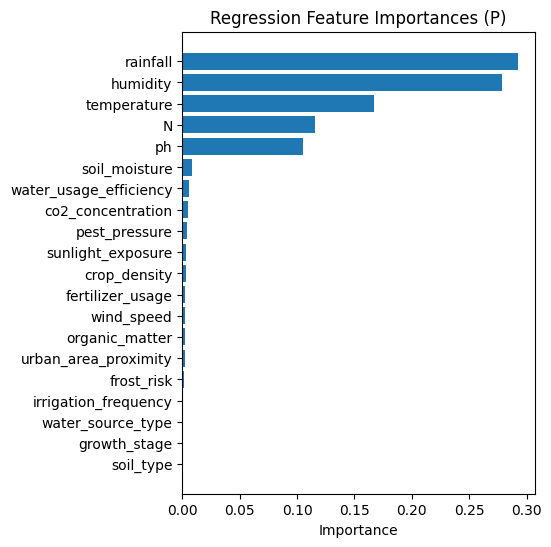

In [24]:
# --- Feature Importance Visualization ---
plt.figure(figsize=(10, 6))
feature_importances_reg = gbr.estimators_[0].feature_importances_
sorted_idx_reg = feature_importances_reg.argsort()
plt.subplot(1, 2, 1)
plt.barh(X.columns[sorted_idx_reg], feature_importances_reg[sorted_idx_reg])
plt.title('Regression Feature Importances (P)')
plt.xlabel('Importance')

In [15]:
# --- Model Training ---
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_clf_train)

RandomForestClassifier(random_state=42)

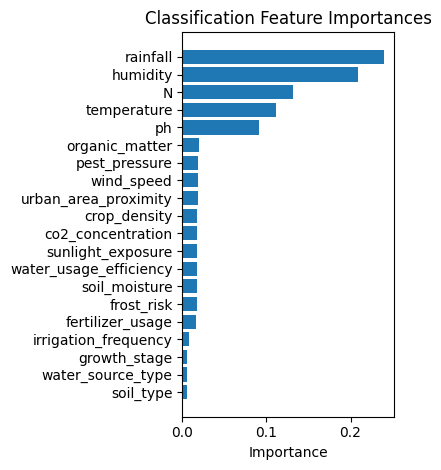

In [21]:
# Classification Feature Importance
plt.subplot(1, 2, 2)
feature_importances_clf = rf_clf.feature_importances_
sorted_idx_clf = feature_importances_clf.argsort()
plt.barh(X.columns[sorted_idx_clf], feature_importances_clf[sorted_idx_clf])
plt.title('Classification Feature Importances')
plt.xlabel('Importance')

plt.tight_layout()
plt.show()

In [27]:
# Droping unimportant columns
X = data.drop(columns=['water_usage_efficiency', 'frost_risk', 'irrigation_frequency',
                         'crop_density', 'pest_pressure', 'fertilizer_usage', 'label', 'P', 'K'])
y_reg = data[['P','K']]
y_clf = data['label']

# Encode categorical columns in X if needed
for col in X.columns:
    if X[col].dtype == 'object':
        print(f"Encoding categorical feature: {col}")
        label_encoder_col = LabelEncoder()
        X[col] = label_encoder_col.fit_transform(X[col])


# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)


# Encode the classification target variable
label_encoder = LabelEncoder()
y_clf = label_encoder.fit_transform(y_clf)

In [28]:
# Split data into training, validation, and testing sets
X_train, X_temp, y_reg_train, y_reg_temp, y_clf_train, y_clf_temp = train_test_split(
    X_scaled, y_reg, y_clf, test_size=0.3, random_state=42
)
X_val, X_test, y_reg_val, y_reg_test, y_clf_val, y_clf_test = train_test_split(
    X_temp, y_reg_temp, y_clf_temp, test_size=0.5, random_state=42
)

In [29]:
# --- Model Training---
gbr = MultiOutputRegressor(GradientBoostingRegressor(random_state=42))
gbr.fit(X_train, y_reg_train)

MultiOutputRegressor(estimator=GradientBoostingRegressor(random_state=42))

Text(0.5, 0, 'Importance')

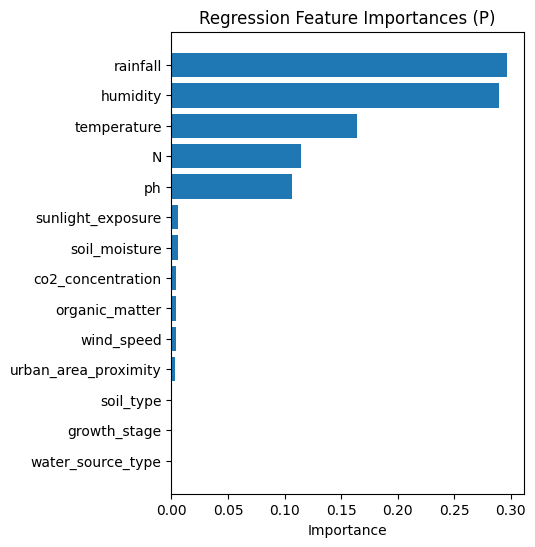

In [30]:
# --- Feature Importance Visualization ---
plt.figure(figsize=(10, 6))
feature_importances_reg = gbr.estimators_[0].feature_importances_
sorted_idx_reg = feature_importances_reg.argsort()
plt.subplot(1, 2, 1)
plt.barh(X.columns[sorted_idx_reg], feature_importances_reg[sorted_idx_reg])
plt.title('Regression Feature Importances (P)')
plt.xlabel('Importance')

In [31]:
# --- Model Training ---
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_clf_train)

RandomForestClassifier(random_state=42)

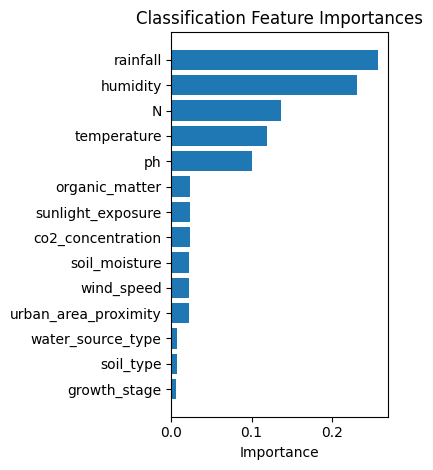

In [32]:
# Classification Feature Importance
plt.subplot(1, 2, 2)
feature_importances_clf = rf_clf.feature_importances_
sorted_idx_clf = feature_importances_clf.argsort()
plt.barh(X.columns[sorted_idx_clf], feature_importances_clf[sorted_idx_clf])
plt.title('Classification Feature Importances')
plt.xlabel('Importance')

plt.tight_layout()
plt.show()

In [33]:
y_reg_val_pred = gbr.predict(X_val)
r2_scores_val = r2_score(y_reg_val, y_reg_val_pred, multioutput='raw_values')
mae_scores_val = [mean_absolute_error(y_reg_val.iloc[:, i], y_reg_val_pred[:, i]) 
                  for i in range(y_reg_val.shape[1])]

print("\nRegression Model Validation Evaluation:")
for i, target in enumerate(y_reg.columns):
    print(f"{target}:")
    print(f"  R-squared: {r2_scores_val[i]:.4f}")
    print(f"  Mean Absolute Error: {mae_scores_val[i]:.4f}")


Regression Model Validation Evaluation:
P:
  R-squared: 0.7066
  Mean Absolute Error: 13.1289
K:
  R-squared: 0.8220
  Mean Absolute Error: 13.9082


In [34]:
# Classification Evaluation
y_clf_val_pred = rf_clf.predict(X_val)
val_accuracy = accuracy_score(y_clf_val, y_clf_val_pred)
print("\nClassification Model Validation Evaluation:")
print(f"Accuracy: {val_accuracy:.4f}")
print("\nDetailed Classification Report:")
print(classification_report(y_clf_val, y_clf_val_pred, 
                            target_names=label_encoder.classes_))


Classification Model Validation Evaluation:
Accuracy: 0.9394

Detailed Classification Report:
              precision    recall  f1-score   support

       apple       0.88      0.95      0.91        22
      banana       1.00      0.93      0.97        15
   blackgram       0.89      1.00      0.94        16
    chickpea       1.00      0.85      0.92        13
     coconut       0.93      1.00      0.96        13
      coffee       1.00      1.00      1.00        15
      cotton       0.94      1.00      0.97        15
      grapes       1.00      1.00      1.00        11
        jute       0.85      1.00      0.92        17
 kidneybeans       0.93      1.00      0.97        14
      lentil       0.92      1.00      0.96        11
       maize       0.91      1.00      0.95        10
       mango       0.73      1.00      0.85        11
   mothbeans       1.00      0.85      0.92        20
    mungbean       1.00      1.00      1.00        16
   muskmelon       1.00      1.00      1

In [35]:
# Regression on Test Set
y_reg_test_pred = gbr.predict(X_test)
r2_scores_test = r2_score(y_reg_test, y_reg_test_pred, multioutput='raw_values')
mae_scores_test = [mean_absolute_error(y_reg_test.iloc[:, i], y_reg_test_pred[:, i]) 
                   for i in range(y_reg_test.shape[1])]

print("\nFinal Test Set Regression Evaluation:")
for i, target in enumerate(y_reg.columns):
    print(f"{target}:")
    print(f"  R-squared: {r2_scores_test[i]:.4f}")
    print(f"  Mean Absolute Error: {mae_scores_test[i]:.4f}")


Final Test Set Regression Evaluation:
P:
  R-squared: 0.6650
  Mean Absolute Error: 12.7863
K:
  R-squared: 0.7585
  Mean Absolute Error: 13.9999


In [37]:
# Classification on Test Set
y_clf_test_pred = rf_clf.predict(X_test)
test_accuracy = accuracy_score(y_clf_test, y_clf_test_pred)
print("\nFinal Test Set Classification Evaluation:")
print(f"Accuracy: {test_accuracy:.4f}")
print("\nDetailed Classification Report:")
print(classification_report(y_clf_test, y_clf_test_pred, 
                            target_names=label_encoder.classes_))


Final Test Set Classification Evaluation:
Accuracy: 0.9455

Detailed Classification Report:
              precision    recall  f1-score   support

       apple       0.69      0.92      0.79        12
      banana       1.00      0.91      0.95        11
   blackgram       1.00      1.00      1.00        10
    chickpea       1.00      1.00      1.00        21
     coconut       0.95      1.00      0.98        20
      coffee       0.94      1.00      0.97        15
      cotton       0.93      1.00      0.96        13
      grapes       1.00      1.00      1.00        12
        jute       0.84      0.94      0.89        17
 kidneybeans       1.00      1.00      1.00        22
      lentil       1.00      1.00      1.00        11
       maize       1.00      1.00      1.00        16
       mango       0.88      1.00      0.93        21
   mothbeans       1.00      1.00      1.00        14
    mungbean       1.00      1.00      1.00        14
   muskmelon       1.00      1.00      1.0

In [36]:
joblib.dump(gbr, 'gbr_regressor_model.pkl')
joblib.dump(rf_clf, 'rf_classifier_model.pkl')
joblib.dump(label_encoder, "label_encoder.pkl")
print("\nModels saved successfully.")